# Bayesian Networks

Bayesian networks are a powerful inference tool, in which a set of variables are represented as nodes, and the lack of an edge represents a conditional independence statement between the two variables, and an edge represents a dependence between the two variables. One of the powerful components of a Bayesian network is the ability to infer the values of certain variables, given observed values for another set of variables. These are referred to as the 'hidden' and 'observed' variables respectively, and need not be set at the time the network is created. The same network can have a different set of variables be hidden or observed between two data points. The more values which are observed, the closer the inferred values will be to the truth.

While Bayesian networks can have extremely complex emission probabilities, usually Gaussian or conditional Gaussian distributions, pomegranate currently supports only discrete Bayesian networks. Bayesian networks are explicitly turned into Factor Graphs when inference is done, wherein the Bayesian network is turned into a bipartite graph with all variables having marginal nodes on one side, and joint tables on the other.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import numpy as np

from pomegranate import *

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

## The Monty Hall Gameshow

The Monty Hall problem (***Idź na całość***) arose from the gameshow Let's Make a Deal, where a guest had to choose which one of three doors had a prize behind it. The twist was that after the guest chose, the host, originally Monty Hall, would then open one of the doors the guest did not pick and ask if the guest wanted to switch which door they had picked. Initial inspection may lead you to believe that if there are only two doors left, there is a 50-50 chance of you picking the right one, and so there is no advantage one way or the other. However, it has been proven both through simulations and analytically that there is in fact a 66% chance of getting the prize if the guest switches their door, regardless of the door they initially went with.

We can reproduce this result using Bayesian networks with three nodes, one for the guest, one for the prize, and one for the door Monty chooses to open. The door the guest initially chooses and the door the prize is behind are completely random processes across the three doors, but the door which Monty opens is dependent on both the door the guest chooses (it cannot be the door the guest chooses), and the door the prize is behind (it cannot be the door with the prize behind it).

To create the Bayesian network in pomegranate, we first create the distributions which live in each node in the graph. For a discrete (aka categorical) bayesian network we use DiscreteDistribution objects for the root nodes and ConditionalProbabilityTable objects for the inner and leaf nodes. The columns in a ConditionalProbabilityTable correspond to the order in which the parents (the second argument) are specified, and the last column is the value the ConditionalProbabilityTable itself takes. In the case below, the first column corresponds to the value 'guest' takes, then the value 'prize' takes, and then the value that 'monty' takes. 'B', 'C', 'A' refers then to the probability that Monty reveals door 'A' given that the guest has chosen door 'B' and that the prize is actually behind door 'C', or P(Monty='A'|Guest='B', Prize='C').

In [3]:
# The guests initial door selection is completely random
guest = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

# The door the prize is behind is also completely random
prize = DiscreteDistribution({'A': 1./3, 'B': 1./3, 'C': 1./3})

    # Monty is dependent on both the guest and the prize. 
monty = ConditionalProbabilityTable(
        [[ 'A', 'A', 'A', 0.0 ],
         [ 'A', 'A', 'B', 0.5 ],
         [ 'A', 'A', 'C', 0.5 ],
         [ 'A', 'B', 'A', 0.0 ],
         [ 'A', 'B', 'B', 0.0 ],
         [ 'A', 'B', 'C', 1.0 ],
         [ 'A', 'C', 'A', 0.0 ],
         [ 'A', 'C', 'B', 1.0 ],
         [ 'A', 'C', 'C', 0.0 ],
         [ 'B', 'A', 'A', 0.0 ],
         [ 'B', 'A', 'B', 0.0 ],
         [ 'B', 'A', 'C', 1.0 ],
         [ 'B', 'B', 'A', 0.5 ],
         [ 'B', 'B', 'B', 0.0 ],
         [ 'B', 'B', 'C', 0.5 ],
         [ 'B', 'C', 'A', 1.0 ],
         [ 'B', 'C', 'B', 0.0 ],
         [ 'B', 'C', 'C', 0.0 ],
         [ 'C', 'A', 'A', 0.0 ],
         [ 'C', 'A', 'B', 1.0 ],
         [ 'C', 'A', 'C', 0.0 ],
         [ 'C', 'B', 'A', 1.0 ],
         [ 'C', 'B', 'B', 0.0 ],
         [ 'C', 'B', 'C', 0.0 ],
         [ 'C', 'C', 'A', 0.5 ],
         [ 'C', 'C', 'B', 0.5 ],
         [ 'C', 'C', 'C', 0.0 ]], [guest, prize])  

# Przykładowo
# P(Monty='A'|Guest='B', Prize='C') = 1
# Jeśli gość wybrał B a nagroda jest w C, Monty musi odkryć A czyli nie ma wyboru
# Jeśli gość odkrył nagrodę, to Monty może losowo wybrać jedne z dwóch drzwi, bo i tak nie odkryje nagrody
# Wówczas: P(Monty='B'|Guest='C', Prize='C') = 0.5 i P(Monty='A'|Guest='C', Prize='C') = 0.5

In [4]:
# State objects hold both the distribution, and a high level name.
s1 = State(guest, name="guest")
s2 = State(prize, name="prize")
s3 = State(monty, name="monty")

In [5]:
# Create the Bayesian network object with a useful name
model = BayesianNetwork("Monty Hall Problem")

# Add the three states to the network 
model.add_states(s1, s2, s3)

In [6]:
# Add edges which represent conditional dependencies, where the second node is 
# conditionally dependent on the first node (Monty is dependent on both guest and prize)
# Oznacza to, że wybór Montiego jest zależny od dwóch zdarzeń losowych
# Wystąpienie nagrody i wybór gościa są od siebie niezależne
model.add_edge(s1, s3)
model.add_edge(s2, s3)

In [7]:
model.bake()

In [8]:
# model.plot("here.jpg")

### Prawdopodbieństwo sekwencji zdarzeń

In [9]:
model.probability([['A', 'B', 'C']])

0.11111111111111109

In [10]:
model.predict_proba({})

array([{
           "class" : "Distribution",
           "dtype" : "str",
           "name" : "DiscreteDistribution",
           "parameters" : [
               {
                   "A" : 0.33333333333333337,
                   "B" : 0.33333333333333337,
                   "C" : 0.33333333333333337
               }
           ],
           "frozen" : false
       }                                     ,
       {
           "class" : "Distribution",
           "dtype" : "str",
           "name" : "DiscreteDistribution",
           "parameters" : [
               {
                   "A" : 0.33333333333333337,
                   "B" : 0.33333333333333337,
                   "C" : 0.33333333333333337
               }
           ],
           "frozen" : false
       }                                     ,
       {
           "class" : "Distribution",
           "dtype" : "str",
           "name" : "DiscreteDistribution",
           "parameters" : [
               {
                   "A" : 

In [11]:
model.predict_proba([[None, None, None]])

[array([{
            "class" : "Distribution",
            "dtype" : "str",
            "name" : "DiscreteDistribution",
            "parameters" : [
                {
                    "A" : 0.33333333333333337,
                    "B" : 0.33333333333333337,
                    "C" : 0.33333333333333337
                }
            ],
            "frozen" : false
        }                                     ,
        {
            "class" : "Distribution",
            "dtype" : "str",
            "name" : "DiscreteDistribution",
            "parameters" : [
                {
                    "A" : 0.33333333333333337,
                    "B" : 0.33333333333333337,
                    "C" : 0.33333333333333337
                }
            ],
            "frozen" : false
        }                                     ,
        {
            "class" : "Distribution",
            "dtype" : "str",
            "name" : "DiscreteDistribution",
            "parameters" : [
           

In [12]:
model.predict_proba([['A', None, None]])

[array(['A', {
                 "class" : "Distribution",
                 "dtype" : "str",
                 "name" : "DiscreteDistribution",
                 "parameters" : [
                     {
                         "A" : 0.3333333333333333,
                         "B" : 0.3333333333333333,
                         "C" : 0.3333333333333333
                     }
                 ],
                 "frozen" : false
             }                                    ,
        {
            "class" : "Distribution",
            "dtype" : "str",
            "name" : "DiscreteDistribution",
            "parameters" : [
                {
                    "A" : 0.0,
                    "B" : 0.49999999999999983,
                    "C" : 0.49999999999999983
                }
            ],
            "frozen" : false
        }                                     ], dtype=object)]

In [13]:
model.predict_proba([{'guest': 'A', 'monty': 'C'}])

[array(['A', {
                 "class" : "Distribution",
                 "dtype" : "str",
                 "name" : "DiscreteDistribution",
                 "parameters" : [
                     {
                         "A" : 0.3333333333333334,
                         "B" : 0.6666666666666664,
                         "C" : 0.0
                     }
                 ],
                 "frozen" : false
             }                                    , 'C'], dtype=object)]

## Imputation Given Structured Constraints

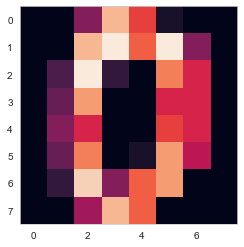

In [14]:
from sklearn.datasets import load_digits

data = load_digits()
X, _ = data.data, data.target

plt.imshow(X[0].reshape(8, 8))
plt.grid(False)
plt.show()

X = X[:,:16]
X = (X > numpy.median(X)).astype('float64')
# Zero

Now let's remove a large portion of the pixels randomly from each of the images. We can do that with numpy arrays by setting missing values to `np.nan`.

In [15]:
numpy.random.seed(111)

i = numpy.random.randint(X.shape[0], size=10000)
j = numpy.random.randint(X.shape[1], size=10000)

X_missing = X.copy()
X_missing[i, j] = numpy.nan
X_missing

array([[ 0.,  0.,  1., ...,  1.,  1.,  0.],
       [ 0., nan, nan, ..., nan,  0.,  0.],
       [ 0.,  0., nan, ...,  1.,  0.,  0.],
       ...,
       [ 0.,  0., nan, ...,  1.,  0., nan],
       [ 0., nan, nan, ...,  1., nan,  0.],
       [nan,  0.,  1., ..., nan,  0., nan]])

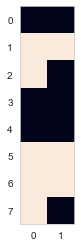

In [16]:
plt.imshow(X[0].reshape(8, 2))
plt.grid(False)
plt.show()

We can set up a baseline for how good an imputation is by using the average pixel value as a replacement. Because this is binary data, we can use the mean absolute error to measure how good these approaches are on imputing the pixels that are not observed

In [17]:
from fancyimpute import SimpleFill

y_pred = SimpleFill().fit_transform(X_missing)[i, j]
numpy.abs(y_pred - X[i, j]).mean()

0.1954958904004812

In [18]:
from fancyimpute import IterativeSVD

y_pred = IterativeSVD(verbose=False).fit_transform(X_missing)[i, j]
numpy.abs(y_pred - X[i, j]).mean()

0.2664581859437127

Now, we can try building a Bayesian network using the **[Chow-Liu algorithm](https://web.stanford.edu/class/ee376a/files/2017-18/chow-liu.pdf)** and then use the resulting network to fill in the matrix.

In [19]:
y_hat = BayesianNetwork.from_samples(X_missing, max_parents=1).predict(X_missing)
numpy.abs(numpy.array(y_hat)[i, j] - X[i, j]).mean()

0.1092

In [23]:
# plt.imshow(y_hat[0].reshape(8, 2))
# plt.grid(False)
# plt.show() 

In [20]:
from fancyimpute import KNN

y_pred = KNN(verbose=False).fit_transform(X_missing)[i, j]
numpy.abs(y_pred - X[i, j]).mean()

0.16290500020624946

## API

In [32]:
np.random.seed(111)

X = np.random.randint(2, size=(15, 15))
X[:,5] = X[:,4] = X[:,3]
X[:,11] = X[:,12] = X[:,13]

model = BayesianNetwork.from_samples(X)
# model.plot('lol.png')

In [33]:
model.predict([[False, False, False, False, None, None, False, None, False, None, True, None, None, True, False]])

[array([False, False, False, False, 0, 0, False, 1, False, 0, True, 1, 1,
        True, False], dtype=object)]

In [34]:
model.predict_proba([[False, False, False, False, None, None, False, None, False, None, 
                      True, None, None, True, False]])

[array([False, False, False, False, {
                                        "class" : "Distribution",
                                        "dtype" : "numpy.int32",
                                        "name" : "DiscreteDistribution",
                                        "parameters" : [
                                            {
                                                "0" : 1.0,
                                                "1" : 0.0
                                            }
                                        ],
                                        "frozen" : false
                                    }                                   ,
        {
            "class" : "Distribution",
            "dtype" : "numpy.int32",
            "name" : "DiscreteDistribution",
            "parameters" : [
                {
                    "0" : 1.0,
                    "1" : 0.0
                }
            ],
            "frozen" : false
        }         